In [1]:
%matplotlib inline
from pylab import imshow
import numpy as np
import cv2
import torch
import albumentations as albu
!pip install iglovikov_helper_functions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00


In [2]:
!pip install cloths_segmentation  > /dev/null

In [49]:
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image
from cloths_segmentation.pre_trained_models import create_model
import random
img_name = random.randint(0, 58)
model = create_model("Unet_2020-10-30")
model.eval();
img_path = "2.jpg"

/usr/local/lib/python3.8/dist-packages/torch/hub.py:651: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


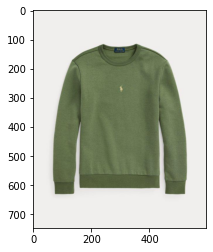

In [50]:
image = load_rgb(img_path)
imshow(image)

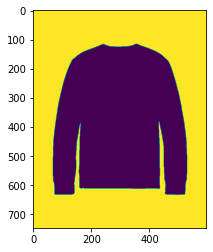

In [51]:

transform = albu.Compose([albu.Normalize(p=1)], p=1)
padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)
x = transform(image=padded_image)["image"]
x = torch.unsqueeze(tensor_from_rgb_image(x), 0)
with torch.no_grad():
  prediction = model(x)[0][0]
mask = (prediction > 0).cpu().numpy().astype(np.uint8)
mask = unpad(mask, pads)
mask = cv2.bitwise_not(mask)
imshow(mask)

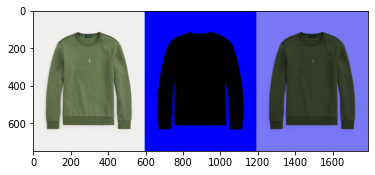

In [52]:
def preprocess(cloth, cloth_mask):
  background = np.full_like(cloth, (0, 0, 255))
  mask_inv = cv2.bitwise_not(cloth_mask)
  background = cv2.bitwise_and(background, background, mask=mask_inv)
  lower_black = np.array([0, 0, 0])
  upper_black = np.array([40, 40, 40])

  # Threshold the image to get binary mask for black pixels
  mask_black = cv2.inRange(background, lower_black, upper_black)

  # Change black pixels to green
  background[mask_black > 0] = [0, 255, 0]
  lower_blue = np.array([0, 0, 100])
  upper_blue = np.array([140, 255, 255])

  # Threshold the image to get binary mask for blue pixels
  mask_blue = cv2.inRange(background, lower_blue, upper_blue)

  # Change blue pixels to black
  background[mask_blue > 0] = [0, 0, 0]
  lower_green = np.array([0, 100, 0])
  upper_green = np.array([100, 255, 100])

  # Threshold the image to get binary mask for green pixels
  mask_green = cv2.inRange(background, lower_green, upper_green)

  # Change green pixels to blue
  background[mask_green > 0] = [0, 0, 255]
  dst = cv2.addWeighted(cloth, 0.5, background, 0.5, 0)
  imshow(np.hstack([cloth, background, dst]))
preprocess(image, mask)

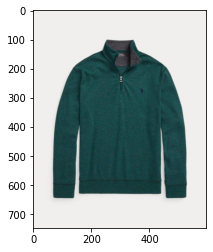

In [53]:
#Test on another image
img_path = "1.jpg"
image = load_rgb(img_path)
imshow(image)

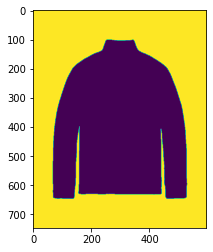

In [54]:

transform = albu.Compose([albu.Normalize(p=1)], p=1)
padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)
x = transform(image=padded_image)["image"]
x = torch.unsqueeze(tensor_from_rgb_image(x), 0)
with torch.no_grad():
  prediction = model(x)[0][0]
mask = (prediction > 0).cpu().numpy().astype(np.uint8)
mask = unpad(mask, pads)
mask = cv2.bitwise_not(mask)
imshow(mask)

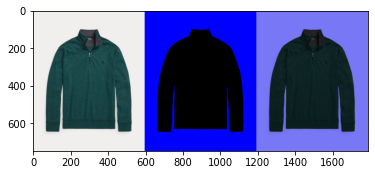

In [55]:
preprocess(image, mask)